# Importing Required Libraries

In [1]:
import os
import time
import warnings
import numpy as np
from numpy import newaxis
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

/Users/masi/.pyenv/versions/DL/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# Importing the Dataset

In [2]:
#read the bitcoin price dataset
# dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
bitcoin_price = pd.read_csv(filepath_or_buffer='cryptocurrencypricehistory/bitcoin_price.csv')

In [3]:
bitcoin_price.head(5)

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Oct 03, 2017",4408.46,4432.47,4258.89,4317.48,"1,288,020,000","73,181,300,000"
1,"Oct 02, 2017",4395.81,4470.23,4377.46,4409.32,"1,431,730,000","72,963,200,000"
2,"Oct 01, 2017",4341.05,4403.74,4269.81,4403.74,"1,208,210,000","72,047,300,000"
3,"Sep 30, 2017",4166.11,4358.43,4160.86,4338.71,"1,207,450,000","69,136,600,000"
4,"Sep 29, 2017",4171.62,4214.63,4039.29,4163.07,"1,367,050,000","69,219,200,000"


In [4]:
bitcoin_data = bitcoin_price[['Date', 'Close']]

In [5]:
bitcoin_data.head(5)

,Date,Close
0,"Oct 03, 2017",4317.48
1,"Oct 02, 2017",4409.32
2,"Oct 01, 2017",4403.74
3,"Sep 30, 2017",4338.71
4,"Sep 29, 2017",4163.07



# Data Exploration

In [6]:
#converting date format from string to datetime
# bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
bitcoin_data.loc[0:, 'Date'] = pd.to_datetime(bitcoin_data['Date'])

/Users/masi/.pyenv/versions/DL/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [7]:
bitcoin_data['Close'].dtypes

dtype('float64')

In [8]:
bitcoin_ts = bitcoin_data.set_index('Date')

In [9]:
bitcoin_ts.head(5)

,Close
Date,
2017-10-03,4317.48
2017-10-02,4409.32
2017-10-01,4403.74
2017-09-30,4338.71
2017-09-29,4163.07


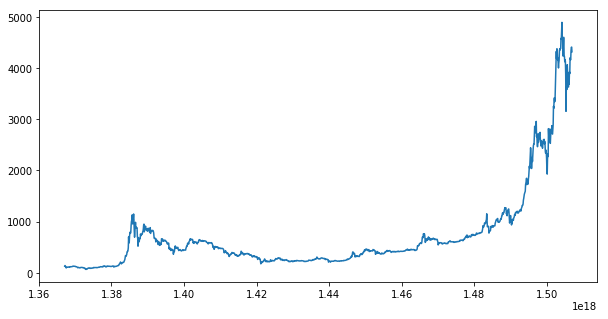

In [10]:
#Closing price visualization
plt.plot(bitcoin_ts)

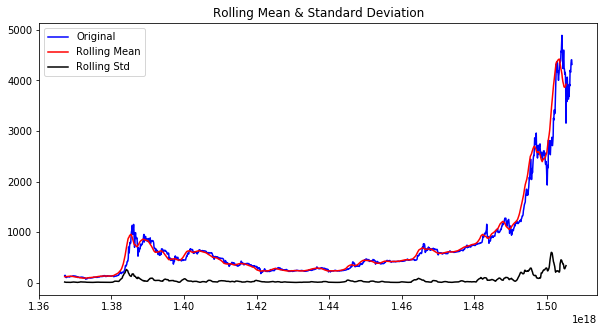

In [11]:
#Calculating rolling statistics to check for a trend/seasonality

rolling_mean = bitcoin_ts.rolling(window=20,center=False).mean()
rolling_std = bitcoin_ts.rolling(window=20,center=False).std()

#Plot rolling statistics:
orig = plt.plot(bitcoin_ts, color='blue',label='Original')
mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

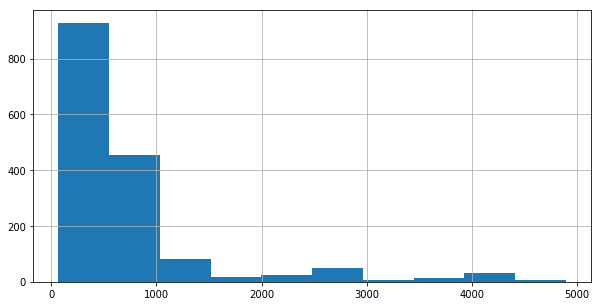

In [12]:
#Visualizing data distribution to check for Stationarity
bitcoin_ts['Close'].hist()
plt.show()

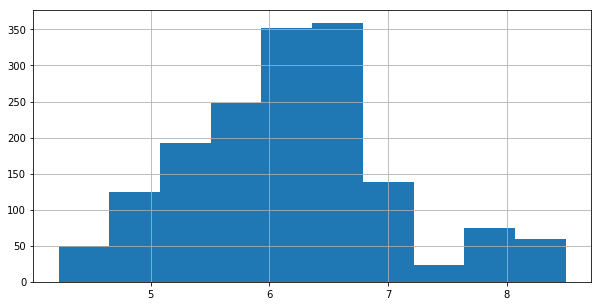

In [13]:
#transforming the data and checking for the Stationarity
bitcoin_log = np.log(bitcoin_ts)
bitcoin_log['Close'].hist()
plt.show()

# Data Preprocessing

### Converting the date column from string to Datetime format for further processing. Finding correlation between different features and removing the highly correlated features


In [14]:
bitcoin_price.loc[0:, 'Date'] = pd.to_datetime(bitcoin_price['Date'])

In [15]:
bitcoin_price = bitcoin_price.set_index('Date')

In [16]:
bitcoin_price.head(5)

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2017-10-03,4408.46,4432.47,4258.89,4317.48,"1,288,020,000","73,181,300,000"
2017-10-02,4395.81,4470.23,4377.46,4409.32,"1,431,730,000","72,963,200,000"
2017-10-01,4341.05,4403.74,4269.81,4403.74,"1,208,210,000","72,047,300,000"
2017-09-30,4166.11,4358.43,4160.86,4338.71,"1,207,450,000","69,136,600,000"
2017-09-29,4171.62,4214.63,4039.29,4163.07,"1,367,050,000","69,219,200,000"


In [17]:
#correlation between different features
corrmat = bitcoin_price.corr(method='spearman')

In [18]:
corrmat

,Open,High,Low,Close
Open,1.000000,0.998424,0.997903,0.997439
High,0.998424,1.000000,0.996557,0.998590
Low,0.997903,0.996557,1.000000,0.998372
Close,0.997439,0.998590,0.998372,1.000000


#### As the features are highly correlated, we can just choose any one feature (we chose "Close") to predict.

In [19]:
#final dataset
bitcoin_final = bitcoin_price['Close']

In [20]:
bitcoin_final.head(5)

Date
2017-10-03    4317.48
2017-10-02    4409.32
2017-10-01    4403.74
2017-09-30    4338.71
2017-09-29    4163.07
Name: Close, dtype: float64

# Data Modelling

In [21]:
#splitting the data into test and train
splitIndex = int(np.floor(bitcoin_final.shape[0]*0.90))
trainDataset, testDataset = bitcoin_final[:splitIndex], bitcoin_final[splitIndex:]
print ("No. of samples in the training set: ", len(trainDataset))
print ("No. of samples in the test set", len(testDataset))

No. of samples in the training set:  1458
No. of samples in the test set 162


## LSTM Model

In [50]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [51]:
data = bitcoin_final
data.to_csv(path='prices.csv',  sep=',',header=None, index=False)

> Loading data... 
> Data Loaded. Compiling...
> Compilation Time :  0.031614065170288086
Train on 1376 samples, validate on 73 samples
Epoch 1/20
1376/1376 [==============================] - 2s - loss: 0.0155 - val_loss: 0.0108
Epoch 2/20
1376/1376 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0083
Epoch 3/20
1376/1376 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0057
Epoch 4/20
1376/1376 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0056
Epoch 5/20
1376/1376 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0054
Epoch 6/20
1376/1376 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0055
Epoch 7/20
1376/1376 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0051
Epoch 8/20
1376/1376 [==============================] - 0s - loss: 0.0051 - val_loss: 0.0050
Epoch 9/20
1376/1376 [==============================] - 0s - loss: 0.0050 - val_loss: 0.0047
Epoch 10/20
1376/1376 [====

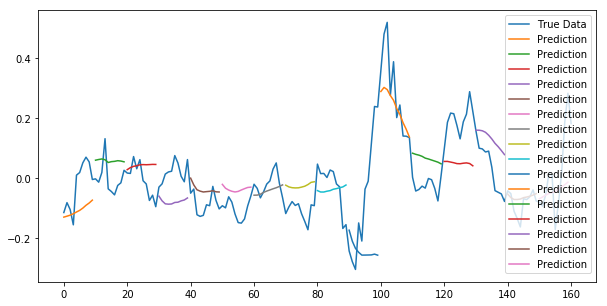

Results for full sequence prediction


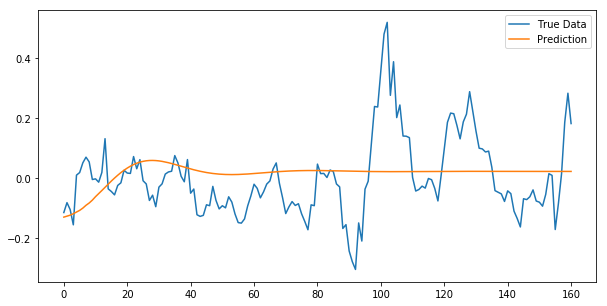

Results for point by point prediction


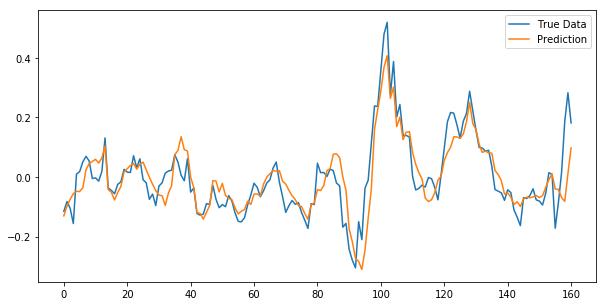

> Loading data... 
> Data Loaded. Compiling...
> Compilation Time :  0.03986406326293945
Train on 1371 samples, validate on 73 samples
Epoch 1/20
1371/1371 [==============================] - 3s - loss: 0.0229 - val_loss: 0.0090
Epoch 2/20
1371/1371 [==============================] - 0s - loss: 0.0108 - val_loss: 0.0077
Epoch 3/20
1371/1371 [==============================] - 0s - loss: 0.0086 - val_loss: 0.0056
Epoch 4/20
1371/1371 [==============================] - 0s - loss: 0.0072 - val_loss: 0.0054
Epoch 5/20
1371/1371 [==============================] - 0s - loss: 0.0071 - val_loss: 0.0046
Epoch 6/20
1371/1371 [==============================] - 0s - loss: 0.0064 - val_loss: 0.0044
Epoch 7/20
1371/1371 [==============================] - 0s - loss: 0.0060 - val_loss: 0.0041
Epoch 8/20
1371/1371 [==============================] - 0s - loss: 0.0057 - val_loss: 0.0046
Epoch 9/20
1371/1371 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0038
Epoch 10/20
1371/1371 [=====

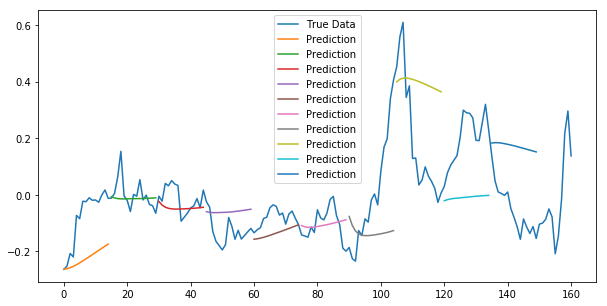

Results for full sequence prediction


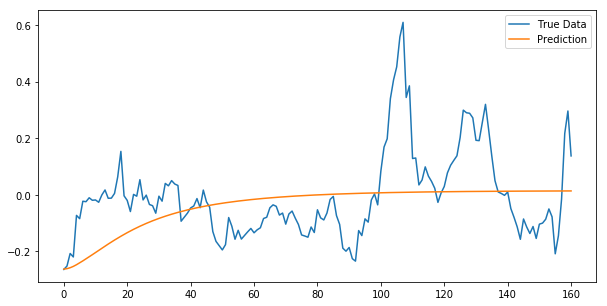

Results for point by point prediction


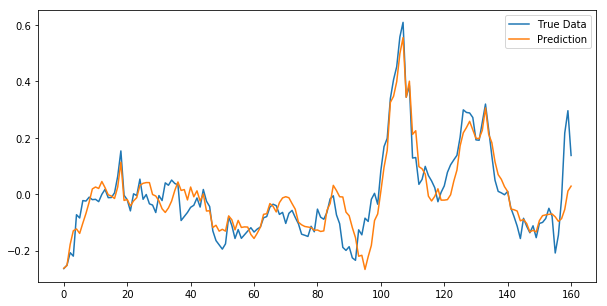

> Loading data... 
> Data Loaded. Compiling...
> Compilation Time :  0.04066801071166992
Train on 1342 samples, validate on 71 samples
Epoch 1/20
1342/1342 [==============================] - 4s - loss: 0.0523 - val_loss: 0.0134
Epoch 2/20
1342/1342 [==============================] - 1s - loss: 0.0149 - val_loss: 0.0096
Epoch 3/20
1342/1342 [==============================] - 1s - loss: 0.0101 - val_loss: 0.0084
Epoch 4/20
1342/1342 [==============================] - 1s - loss: 0.0092 - val_loss: 0.0075
Epoch 5/20
1342/1342 [==============================] - 1s - loss: 0.0085 - val_loss: 0.0065
Epoch 6/20
1342/1342 [==============================] - 1s - loss: 0.0079 - val_loss: 0.0076
Epoch 7/20
1342/1342 [==============================] - 1s - loss: 0.0092 - val_loss: 0.0055
Epoch 8/20
1342/1342 [==============================] - 1s - loss: 0.0075 - val_loss: 0.0069
Epoch 9/20
1342/1342 [==============================] - 2s - loss: 0.0075 - val_loss: 0.0051
Epoch 10/20
1342/1342 [=====

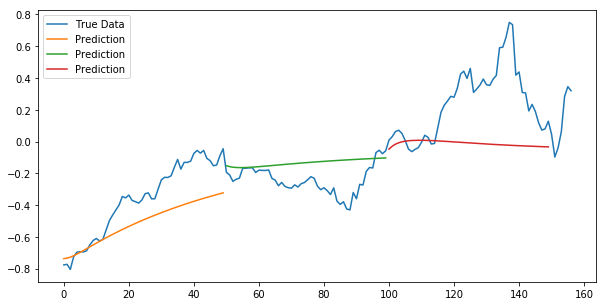

Results for full sequence prediction


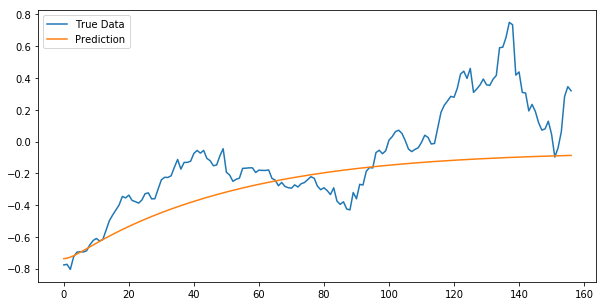

Results for point by point prediction


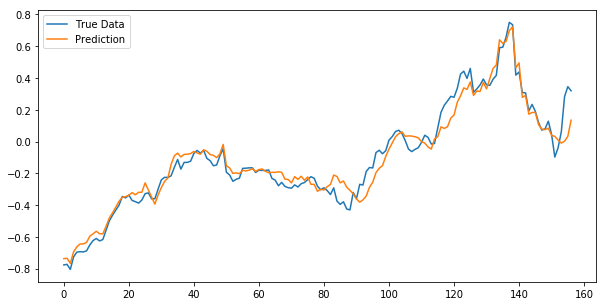

In [52]:
global_start_time = time.time()
epochs = 20
seq_len = [10, 15, 50]
prediction_len = [10, 15, 50]

for l in seq_len:
    print('> Loading data... ')
    X_train, y_train, X_test, y_test = load_data('prices.csv', l, True)

    print('> Data Loaded. Compiling...')
    model = build_model([1, 50, 100, 1])

    model.fit(
        X_train,
        y_train,
        batch_size=512,
        nb_epoch=epochs,
        validation_split=0.05)
    
    predicted_sequences_multiple = predict_sequences_multiple(model, X_test, l, l)
    predicted_sequence_full = predict_sequence_full(model, X_test, l)
    predicted_point_by_point = predict_point_by_point(model, X_test) 
    
    print('Training duration (s) : ', time.time() - global_start_time)
    #     plot_results_multiple(predictions, y_test, 1)
    # MSE_bitcoin_sequences_multiple = mean_squared_error(y_test, predicted_sequences_multiple)
    MSE_bitcoin_sequence_full = mean_squared_error(y_test, predicted_sequence_full)
    MSE_bitcoin_point_by_point = mean_squared_error(y_test, predicted_point_by_point)
    # print("MSE for Bitcoin Multiple Sequence LSTM model: ", MSE_bitcoin_sequences_multiple)
    print("MSE for Bitcoin Full Sequence LSTM model: ", MSE_bitcoin_sequence_full)
    print("MSE for Bitcoin Point-by-Point LSTM model: ", MSE_bitcoin_point_by_point)

    print("Results for multiple sequence prediction")
    plot_results_multiple(predicted_sequences_multiple, y_test, l)
    print("Results for full sequence prediction")
    plot_results(predicted_sequence_full, y_test)
    print("Results for point by point prediction")
    plot_results(predicted_point_by_point, y_test)

## ARIMA Model

In [22]:
X_train_arima = trainDataset
X_test_arima = testDataset

In [23]:
model = ARIMA(X_train_arima, order=(5,1,1))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1488
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8305.326
Method:                       css-mle   S.D. of innovations             64.216
Date:                Wed, 22 Nov 2017   AIC                          16626.653
Time:                        17:37:06   BIC                          16669.094
Sample:                    11-06-2017   HQIC                         16642.470
                         - 10-11-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -12.6818     11.911     -1.065      0.287     -36.028      10.664
ar.L1.D.Close     0.9834      0.026     37.430      0.000       0.932       1.035
ar.L2.D.Close     0.0360      0.037     

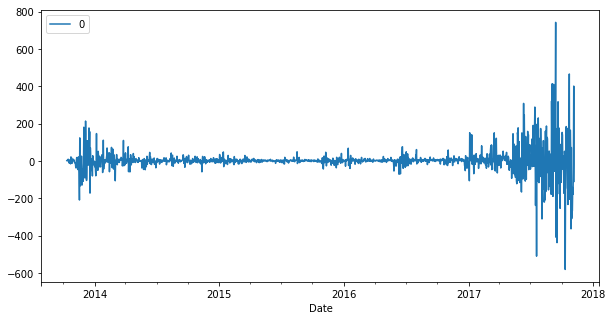

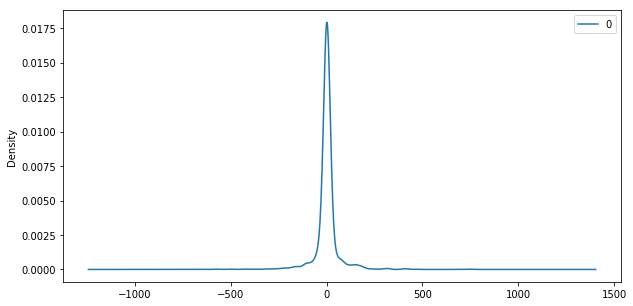

                 0
count  1488.000000
mean      2.493669
std      64.432417
min    -580.257049
25%      -5.814056
50%       2.318896
75%       9.095451
max     742.529704


In [24]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Test MSE: 22.529


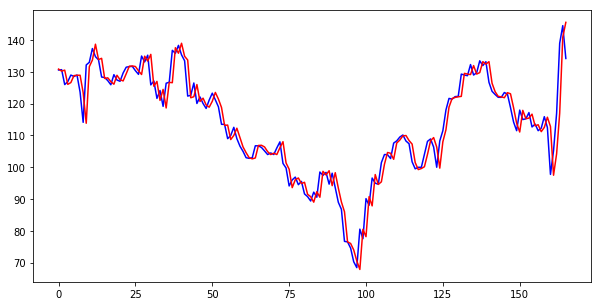

In [25]:
train = X_train_arima.values
test = X_test_arima.values
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(trend='nc', disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test, color='blue')
plt.plot(predictions, color='red')
plt.show()

## FB Prophet

In [26]:
from fbprophet import Prophet

In [27]:
dataProphet = bitcoin_price

In [28]:
dataProphet = dataProphet.reset_index()

In [29]:
dataProphetRed = dataProphet[['Date', 'Close']]

In [30]:
dataProphetRed = dataProphetRed.rename(columns={"Date": "ds", "Close": "y"})

In [31]:
dataProphetRed.head(5)

,ds,y
0,2017-11-07,7144.38
1,2017-11-06,7022.76
2,2017-11-05,7407.41
3,2017-11-04,7379.95
4,2017-11-03,7207.76


In [32]:
dataProphetRed['y_orig'] = dataProphetRed['y'] # to save a copy of the original data..you'll see why shortly. 

In [33]:
#log transform y
dataProphetRed['y'] = np.log(dataProphetRed['y'])

In [34]:
dataProphetRed.head(5)

,ds,y,y_orig
0,2017-11-07,8.874081,7144.38
1,2017-11-06,8.856912,7022.76
2,2017-11-05,8.910236,7407.41
3,2017-11-04,8.906522,7379.95
4,2017-11-03,8.882914,7207.76


In [35]:
model=Prophet(daily_seasonality=True)
model.fit(dataProphetRed)

In [36]:
future_data = model.make_future_dataframe(periods=60)

In [37]:
forecast_data = model.predict(future_data)

In [38]:
forecast_data.head(5)

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2013-04-28,4.879368,4.879368,4.879368,4.691906,4.946701,0.107904,0.107904,0.107904,-0.057299,...,-0.057299,-0.057299,-0.057299,-0.002554,-0.002554,-0.002554,-0.162649,-0.162649,-0.162649,4.822069
1,2013-04-29,4.871662,4.871662,4.871662,4.691468,4.936481,0.107904,0.107904,0.107904,-0.051750,...,-0.051750,-0.051750,-0.051750,0.003400,0.003400,0.003400,-0.163055,-0.163055,-0.163055,4.819912
2,2013-04-30,4.863957,4.863957,4.863957,4.693053,4.939087,0.107904,0.107904,0.107904,-0.051401,...,-0.051401,-0.051401,-0.051401,0.004199,0.004199,0.004199,-0.163504,-0.163504,-0.163504,4.812556
3,2013-05-01,4.856251,4.856251,4.856251,4.679190,4.928896,0.107904,0.107904,0.107904,-0.056318,...,-0.056318,-0.056318,-0.056318,-0.000309,-0.000309,-0.000309,-0.163912,-0.163912,-0.163912,4.799933
4,2013-05-02,4.848545,4.848545,4.848545,4.673474,4.929641,0.107904,0.107904,0.107904,-0.056716,...,-0.056716,-0.056716,-0.056716,-0.000427,-0.000427,-0.000427,-0.164193,-0.164193,-0.164193,4.791829


In [39]:
from sklearn.metrics import mean_absolute_error 

test = dataProphetRed

In [40]:
del test['y_orig']

In [41]:
test.set_index('ds')

,y
ds,
2017-11-07,8.874081
2017-11-06,8.856912
2017-11-05,8.910236
2017-11-04,8.906522
2017-11-03,8.882914
2017-11-02,8.864817
2017-11-01,8.819859
2017-10-31,8.774684
2017-10-30,8.721036


In [42]:
test1 = model.predict(test)

In [43]:
test1

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2013-04-28,4.879368,4.879368,4.879368,4.691386,4.942012,0.107904,0.107904,0.107904,-0.057299,...,-0.057299,-0.057299,-0.057299,-0.002554,-0.002554,-0.002554,-0.162649,-0.162649,-0.162649,4.822069
1,2013-04-29,4.871662,4.871662,4.871662,4.700670,4.936791,0.107904,0.107904,0.107904,-0.051750,...,-0.051750,-0.051750,-0.051750,0.003400,0.003400,0.003400,-0.163055,-0.163055,-0.163055,4.819912
2,2013-04-30,4.863957,4.863957,4.863957,4.689378,4.936637,0.107904,0.107904,0.107904,-0.051401,...,-0.051401,-0.051401,-0.051401,0.004199,0.004199,0.004199,-0.163504,-0.163504,-0.163504,4.812556
3,2013-05-01,4.856251,4.856251,4.856251,4.677733,4.926886,0.107904,0.107904,0.107904,-0.056318,...,-0.056318,-0.056318,-0.056318,-0.000309,-0.000309,-0.000309,-0.163912,-0.163912,-0.163912,4.799933
4,2013-05-02,4.848545,4.848545,4.848545,4.665652,4.917020,0.107904,0.107904,0.107904,-0.056716,...,-0.056716,-0.056716,-0.056716,-0.000427,-0.000427,-0.000427,-0.164193,-0.164193,-0.164193,4.791829
5,2013-05-03,4.840839,4.840839,4.840839,4.660167,4.914727,0.107904,0.107904,0.107904,-0.058536,...,-0.058536,-0.058536,-0.058536,-0.002183,-0.002183,-0.002183,-0.164257,-0.164257,-0.164257,4.782303
6,2013-05-04,4.833134,4.833134,4.833134,4.653045,4.899454,0.107904,0.107904,0.107904,-0.058241,...,-0.058241,-0.058241,-0.058241,-0.002126,-0.002126,-0.002126,-0.164019,-0.164019,-0.164019,4.774892
7,2013-05-05,4.825428,4.825428,4.825428,4.646532,4.889753,0.107904,0.107904,0.107904,-0.058045,...,-0.058045,-0.058045,-0.058045,-0.002554,-0.002554,-0.002554,-0.163395,-0.163395,-0.163395,4.767383
8,2013-05-06,4.817722,4.817722,4.817722,4.637947,4.894624,0.107904,0.107904,0.107904,-0.051002,...,-0.051002,-0.051002,-0.051002,0.003400,0.003400,0.003400,-0.162307,-0.162307,-0.162307,4.766720
9,2013-05-07,4.810016,4.810016,4.810016,4.638574,4.885095,0.107904,0.107904,0.107904,-0.048583,...,-0.048583,-0.048583,-0.048583,0.004199,0.004199,0.004199,-0.160686,-0.160686,-0.160686,4.761434


In [44]:
mean_absolute_error(np.exp(test['y']), np.exp(test1['yhat']))

906.56540429319386

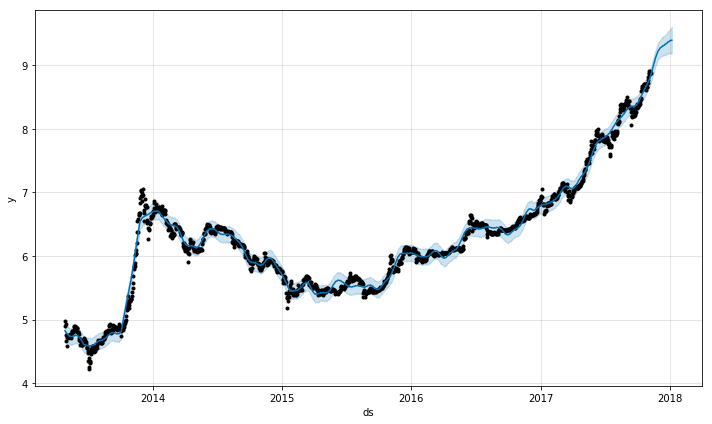

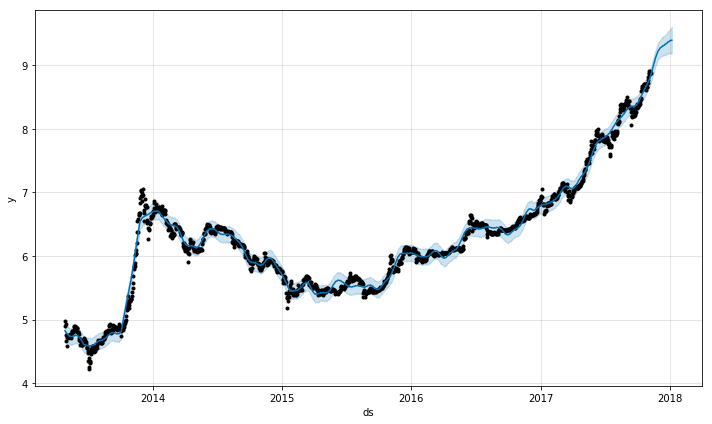

In [45]:
model.plot(forecast_data)

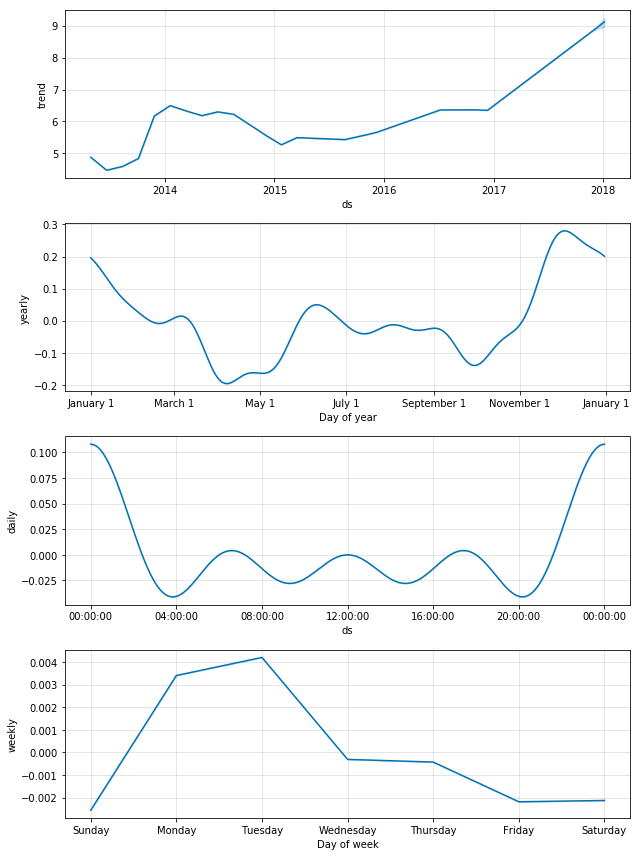

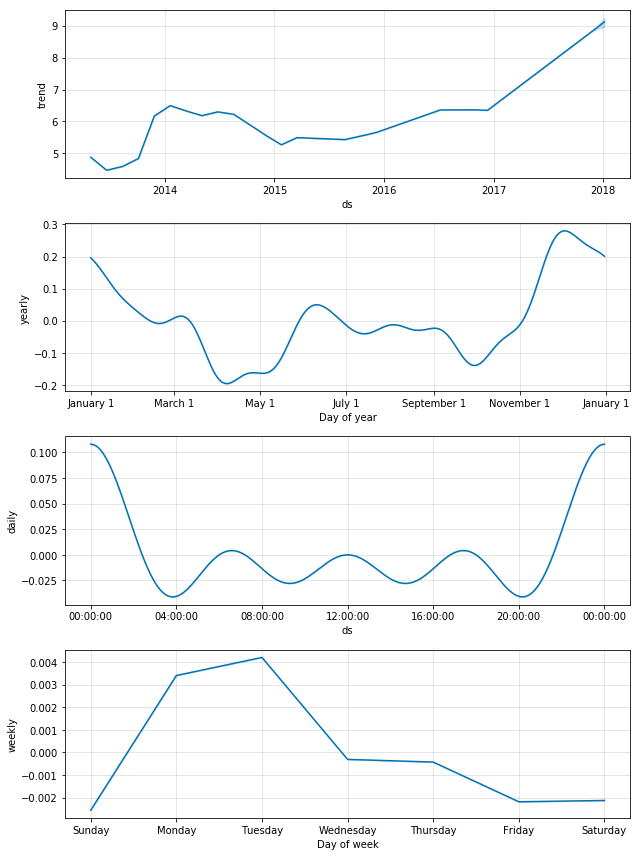

In [46]:
model.plot_components(forecast_data)